This notebook is an implementation of text summarization on the amazon kindle reviews dataset from Kaggle.

[this awesome notebook](https://www.kaggle.com/nehaytamore/abstractive-summarizer-in-keras/notebook) is referenced to help prepare this notebook

In [1]:
import gc # python garbage collector
import os 
import re
import string
import sys
import tarfile
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import chart_studio.plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.feature_extraction import _stop_words as stop_words
from sklearn.model_selection import train_test_split

from IPython.display import Image

from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Activation, concatenate, Embedding, Flatten, Bidirectional, Concatenate
from tensorflow.compat.v1.keras.layers import CuDNNLSTM # CuDNNLSTM is excluded in Tensorflow 2.0
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras import optimizers

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# Print the datasets 
print(os.listdir("../data/"))

['glove-global-vectors-for-word-representation', 'kindle-reviews', 'links.md']


## Exploration

This part will import the datasets, view it and do some processing

In [3]:
# Read the kindle-reviews datasets
kindle_reviews = pd.read_csv("../data/kindle-reviews/kindle_reviews.csv")

In [4]:
# View the shape of the dataset 
# represented in (rows, cols)
print(kindle_reviews.shape)

# View the first few rows of the dataset
kindle_reviews.head()

(982619, 10)


,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [5]:
# Formatting the dataframe display
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_colwidth', 5000)

# Drop unused columns
kindle_reviews.drop(columns=['asin', 'helpful', 'overall', 'reviewTime',
                    'reviewerID', 'reviewerName', 'unixReviewTime'], axis=1, inplace=True)
# Rename the columns
kindle_reviews.columns = ['index', 'review', 'summary']
# Set the first column as index
kindle_reviews.set_index(keys='index', inplace=True)

kindle_reviews.head()

,review,summary
index,,
0,I enjoy vintage books and movies so I enjoyed reading this book. The plot was unusual. Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.,Nice vintage story
1,"This book is a reissue of an old one; the author was born in 1910. It's of the era of, say, Nero Wolfe. The introduction was quite interesting, explaining who the author was and why he's been forgotten; I'd never heard of him.The language is a little dated at times, like calling a gun a &#34;heater.&#34; I also made good use of my Fire's dictionary to look up words like &#34;deshabille&#34; and &#34;Canarsie.&#34; Still, it was well worth a look-see.",Different...
2,"This was a fairly interesting read. It had old- style terminology.I was glad to get to read a story that doesn't have coarse, crasslanguage. I read for fun and relaxation......I like the free ebooksbecause I can check out a writer and decide if they are intriguing,innovative, and have enough of the command of Englishthat they can convey the story without crude language.",Oldie
3,I'd never read any of the Amy Brewster mysteries until this one.. So I am really hooked on them now.,I really liked it.
4,"If you like period pieces - clothing, lingo, you will enjoy this mystery. Author had me guessing at least 2/3 of the way through.",Period Mystery


In [6]:
# Define the model's hyperparameters, considering appropriate percentile of 
# review and summary lengths 

RNN_VOCAB = 10000
MAX_SEQUENCE_REVIEW_LENGTH = 22
MAX_SEQUENCE_SUMMARY_LENGTH = 9
EMBEDDING_DIM = 200
EMBEDDING_FILE_PATH = f"../data/glove-global-vectors-for-word-representation/glove.6B.{EMBEDDING_DIM}d.txt"

## Text preprocessing 

This part we will do pre-processing on the review and summary data, below are the things that will be done

1. Lowercasing
2. Stop words removal
3. Contractions
4. Punctuations removal
5. Unnecessary white space

In [7]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}


def clean_text(text: str, remove_stopwords: bool = True, max_len: int = 20) -> str:
    '''
    This function removes punctuations and selected stopwords from a given text.
    '''
    refined_stop_words = {}

    # Only add stop words to dict if remove_stopwords is specified
    if remove_stopwords:
        # Remove some words so that there are not filtered out.
        # This is because when we remove some word such as 'none', 'not'
        # the meaning of the sentence changes
        refined_stop_words = stop_words.ENGLISH_STOP_WORDS - {"not", "none", "nothing", "nowhere", "never",
                                                                "cannot", "cant", "couldnt", "except", "hasnt",
                                                                "neither", "no", "nobody", "nor", "without"}

    try:
        # Convert to lowercase
        text = text.lower()

        new_text = []
        count = 0

        # Split the text into a list of words
        for word in text.split():
            # Ignore stop words
            if word in refined_stop_words:
                continue

            # Replace contraction with full form
            if word in contractions:
                new_text = new_text + [contractions[word]]
            else:
                new_text = new_text + [word]

            count += 1

        # Make sure the list won't be larger than max_len
        new_text = new_text[0:max_len] if count > max_len else new_text

        # Form a text string separated by a space
        text = ' '.join(new_text)

        # Remove carriage return or newline or tab from text
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        text = regex.sub(' ', text)

        # Remove single character from text and remove whitespaces at both sides
        text = re.sub('\s+', ' ', text).strip()

        # Add start and end tag to the text
        return f"<start> {text} <end>"
    except:
        # Return empty string if error happens
        return ""


In [8]:
# Clean the text in summary and review
kindle_reviews['summary'] = kindle_reviews.summary.apply(lambda x: clean_text(x, True, MAX_SEQUENCE_SUMMARY_LENGTH - 2))
kindle_reviews['review'] = kindle_reviews.review.apply(lambda x: clean_text(x, True, MAX_SEQUENCE_SUMMARY_LENGTH - 2))

kindle_reviews.head()

,review,summary
index,,
0,<start> enjoy vintage books movies enjoyed reading book <end>,<start> nice vintage story <end>
1,<start> book reissue old one author born 1910 <end>,<start> different <end>
2,<start> fairly interesting read old style terminology i glad <end>,<start> oldie <end>
3,<start> i would never read amy brewster mysteries one <end>,<start> really liked it <end>
4,<start> like period pieces clothing lingo enjoy <end>,<start> period mystery <end>


In [9]:
# Put the length of summary/review in a new column
kindle_reviews['summary_length'] = kindle_reviews.summary.apply(lambda x: len(x.split()))
kindle_reviews['review_length'] = kindle_reviews.review.apply(lambda x: len(x.split()))

kindle_reviews.head()

,review,summary,summary_length,review_length
index,,,,
0,<start> enjoy vintage books movies enjoyed reading book <end>,<start> nice vintage story <end>,5,9
1,<start> book reissue old one author born 1910 <end>,<start> different <end>,3,9
2,<start> fairly interesting read old style terminology i glad <end>,<start> oldie <end>,3,10
3,<start> i would never read amy brewster mysteries one <end>,<start> really liked it <end>,5,10
4,<start> like period pieces clothing lingo enjoy <end>,<start> period mystery <end>,4,8


count    982619.000000
mean          9.398958
std           0.848067
min           0.000000
25%           9.000000
50%           9.000000
90%          10.000000
95%          11.000000
99%          12.000000
max         151.000000
Name: review_length, dtype: float64


<AxesSubplot:>

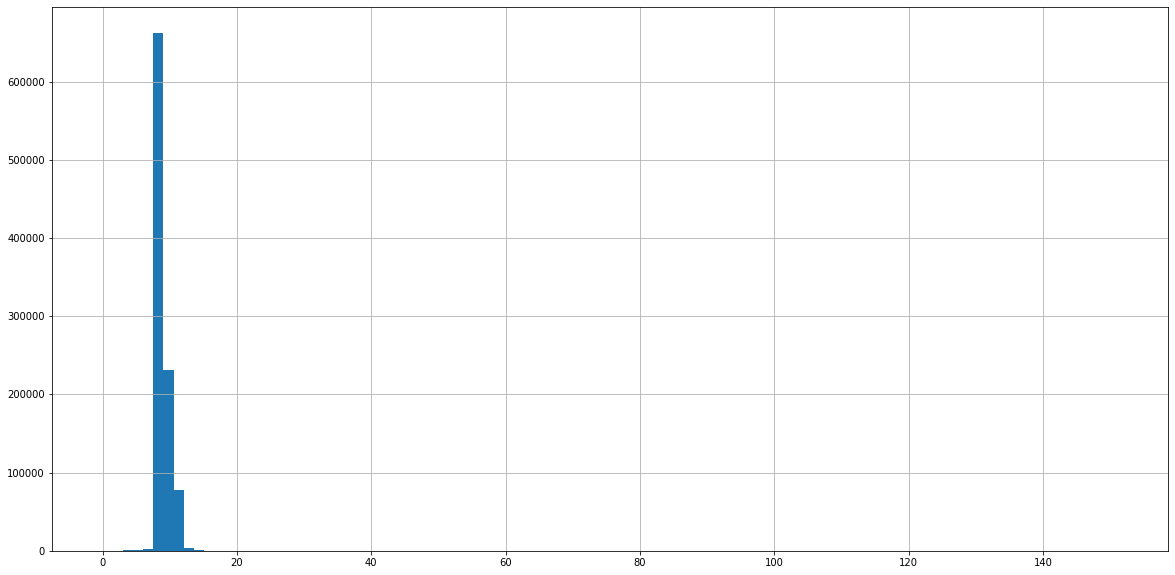

In [10]:
# Print the different percentile of review_length
print(kindle_reviews.review_length.describe(percentiles=[0.25, 0.9, 0.95, 0.99]))

# Plot a histogram of the review_length
kindle_reviews.review_length.hist(bins=100, figsize= (20,10))

count    982619.000000
mean          4.744101
std           1.575008
min           0.000000
25%           4.000000
50%           4.000000
90%           7.000000
95%           8.000000
99%           9.000000
max          39.000000
Name: summary_length, dtype: float64


<AxesSubplot:>

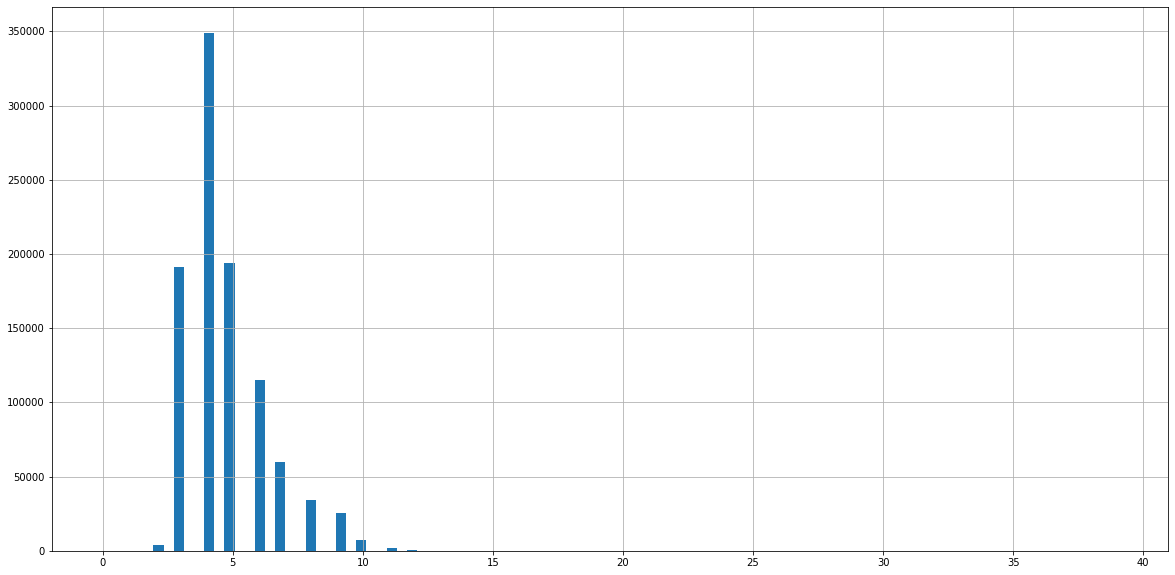

In [11]:
# Print the different percentile of summary_length
print(kindle_reviews.summary_length.describe(percentiles=[0.25, 0.9, 0.95, 0.99]))

# Plot a histogram of the summary_length
kindle_reviews.summary_length.hist(bins=100, figsize= (20,10))

## Define input and output for the model

Since the dataset is large, training will be done in batches.

Before that, we first tokenize the data using Keras's Tokenizer API

In [12]:
# Initialize the tokenizer
tokenize = Tokenizer(num_words=RNN_VOCAB, oov_token='OOV', filters='')

# hstack will stack arrays in horizontal sequence (column)
# @see https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
# fit_on_texts will update internal vocabulary, basically
# create an word_index dictionary from the text given
# @see https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
tokenize.fit_on_texts(np.hstack([kindle_reviews['summary'], kindle_reviews['review']]))

# texts_to_sequence will transform the text given to a sequence of integers
# based on the word_index dictionary 
# @see https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
kindle_reviews['sequence_summary'] = tokenize.texts_to_sequences(kindle_reviews['summary'])
kindle_reviews['sequence_review'] = tokenize.texts_to_sequences(kindle_reviews['review'])

In [13]:
# Print the number of words in the index dictionary
print("Total number of unique words = ", len(tokenize.word_index))

kindle_reviews.head()

Total number of unique words =  114787


,review,summary,summary_length,review_length,sequence_summary,sequence_review
index,,,,,,
0,<start> enjoy vintage books movies enjoyed reading book <end>,<start> nice vintage story <end>,5,9,"[2, 55, 5124, 6, 3]","[2, 98, 5124, 20, 2112, 18, 22, 4, 3]"
1,<start> book reissue old one author born 1910 <end>,<start> different <end>,3,9,"[2, 75, 3]","[2, 4, 1, 156, 86, 23, 1321, 1, 3]"
2,<start> fairly interesting read old style terminology i glad <end>,<start> oldie <end>,3,10,"[2, 1, 3]","[2, 790, 32, 5, 156, 292, 1, 16, 160, 3]"
3,<start> i would never read amy brewster mysteries one <end>,<start> really liked it <end>,5,10,"[2, 13, 34, 15, 3]","[2, 16, 217, 69, 5, 1513, 1, 638, 86, 3]"
4,<start> like period pieces clothing lingo enjoy <end>,<start> period mystery <end>,4,8,"[2, 1350, 92, 3]","[2, 21, 1350, 1712, 8926, 1, 98, 3]"


Although there are 291K unique words in the dataset, due to constraints we are using, the most frequent 10K words to form our vocab. In short, 174K tokens would be treated as unknown words and hence, many times our model will tend to be biased to generate UNK token just cause of it's sheer frequency in the dataset, considering it to be more probable.

 The decoder input should have a start and end token, therefore we add it to our text previously in the `clean_text` function

 Every encoder and decoder input is augmented with '<start>' and preceeded by '<end>'

In [14]:
# Creating dataset for model input output
dataset = {}

# pad_sequences will prepend or postpend 0
# to ensure all sequences have the same length
# @see https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do
dataset['decoder_input'] = pad_sequences(kindle_reviews.sequence_summary, maxlen=MAX_SEQUENCE_SUMMARY_LENGTH, padding='post')

# take only from first to last to exclude '<start>' and '<end>'
kindle_reviews['sequence_summary'] = kindle_reviews.sequence_summary.apply(lambda x: x[1:])
# TODO: revisit here to see whether has to do the same to sequence_review

dataset['decoder_output'] = pad_sequences(kindle_reviews.sequence_summary, maxlen=MAX_SEQUENCE_SUMMARY_LENGTH - 1, padding='post')
dataset['encoder_input'] = pad_sequences(kindle_reviews.sequence_review, maxlen=MAX_SEQUENCE_REVIEW_LENGTH, padding='pre')

In [15]:
dataset['decoder_input'].shape, dataset['decoder_output'].shape, dataset['encoder_input'].shape

((982619, 9), (982619, 8), (982619, 22))

In [16]:
dataset['encoder_input'][:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    2,   98, 5124,   20, 2112,   18,   22,    4,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    2,    4,    1,  156,   86,   23, 1321,    1,    3]])

In [17]:
kindle_val_reviews = kindle_reviews.loc[1000:1005,:].copy()
gc.collect()

0

## Embeddings

In [18]:
class Embeddings:
    '''
    When a corpus is passed, remove the words which are not in the global vocab (GloVe) and use most
    frequent vocab_size number of words.
    '''

    def __init__(self, embedding_dim: int, vocab_size: int):
        # dimension of embedding
        self.embedding_dim = embedding_dim
        # maximum length of vocab
        self.vocab_size = vocab_size

    def readEmbeddings(self, filePath: str) -> dict:
        '''
        Creates and returns a dictionary of {word, embedding values} given
        the filepath of word embeddings 
        '''
        # Dictionary to store key-value pairs of word and embedding values
        wordToEmbeddingDict = {}

        # Open file as read-only
        file = open(filePath, encoding='utf-8')

        # Read all text
        for line in file:
            lineVal = line.split()
            word = lineVal[0]
            embedding = np.asarray(lineVal[1:], dtype='float32')
            wordToEmbeddingDict[word] = embedding

        # Close the file
        file.close()

        return wordToEmbeddingDict

    def indexToEmbedding(self, wordToIndexDict: dict, wordToEmbeddingDict: dict):
        # Form a numpy array pre-filled with 0
        indexToEmbeddingMatrix = np.zeros((self.vocab_size, self.embedding_dim))

        for word, index in wordToIndexDict.items():
            # terminate when reach vocab_size
            if index >= self.vocab_size:
                break
            # if word exists in embeddingDict
            if word in wordToEmbeddingDict.keys():
                # add its embedding value to the matrix
                indexToEmbeddingMatrix[index] = wordToEmbeddingDict[word]
            else:
                # else add a random value to the matrix
                indexToEmbeddingMatrix[index] = np.array(np.random.uniform(-1.0, 1.0, self.embedding_dim))

        return indexToEmbeddingMatrix
    
    def indexToWord(self, wordToIndexDict: dict) -> dict:
        return {index: word for word, index in wordToIndexDict.items()}



In [19]:
# Instantiate an embeddings class
embeddings = Embeddings(embedding_dim=EMBEDDING_DIM, vocab_size=RNN_VOCAB)

# Read the GloVe embedding file
wordToEmbeddingDict = embeddings.readEmbeddings(EMBEDDING_FILE_PATH)

# Create the index to embedding matrix
indexToEmbeddingMatrix = embeddings.indexToEmbedding(tokenize.word_index, wordToEmbeddingDict)


In [20]:
# Create an index to word dictionary from tokenized word_index
indexToWordDict = embeddings.indexToWord(tokenize.word_index)

indexToWordDict

{1: 'OOV',
 2: '<start>',
 3: '<end>',
 4: 'book',
 5: 'read',
 6: 'story',
 7: 'not',
 8: 'great',
 9: 'good',
 10: 'love',
 11: 'series',
 12: 'loved',
 13: 'really',
 14: 's',
 15: 'it',
 16: 'i',
 17: 'short',
 18: 'enjoyed',
 19: 'just',
 20: 'books',
 21: 'like',
 22: 'reading',
 23: 'author',
 24: 'characters',
 25: 'is',
 26: 'did',
 27: 'romance',
 28: 'fun',
 29: 'written',
 30: 'hot',
 31: 'review',
 32: 'interesting',
 33: 'little',
 34: 'liked',
 35: 'time',
 36: 'sweet',
 37: 'wow',
 38: 'stories',
 39: 'cannot',
 40: 'am',
 41: '5',
 42: 'new',
 43: 'wonderful',
 44: 'have',
 45: 'amazing',
 46: 'stars',
 47: 'awesome',
 48: 'way',
 49: 'say',
 50: 'excellent',
 51: 'best',
 52: 'do',
 53: 'know',
 54: 'better',
 55: 'nice',
 56: 'no',
 57: 'wait',
 58: 'thought',
 59: 'start',
 60: 'want',
 61: '34',
 62: 'quick',
 63: 'easy',
 64: 'cute',
 65: '3',
 66: 'got',
 67: 'lot',
 68: 'life',
 69: 'never',
 70: '2',
 71: 'think',
 72: 'sexy',
 73: 'end',
 74: 'novel',
 75: 'di

In [21]:
print(indexToEmbeddingMatrix.shape)

indexToEmbeddingMatrix

(10000, 200)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.69038414,  0.99617175, -0.66145001, ...,  0.47841402,
        -0.3539416 , -0.85777512],
       [-0.00266426, -0.24172284,  0.49090931, ...,  0.70280174,
        -0.94837171,  0.61225534],
       ...,
       [ 0.011854  , -0.48425001, -0.77745003, ..., -0.34296   ,
         0.27983999, -0.15785   ],
       [ 0.62949697, -0.44528246, -0.55955729, ..., -0.20520575,
        -0.26284119, -0.79124569],
       [-0.66188002,  0.035776  , -0.05231   , ...,  0.96761   ,
         0.53670001, -0.64234   ]])

## Define the model

Our model outputs probability of each word in the vocab (10K) probabilities, for each timestep. The 
number of timesteps for decoder are 9 and we have 982K datapoints. To store the decoder output at training
step, we would require (982K * 9 * 10K) float value memory. Thus, it's inefficient to be training the model,
on the entire dataset.

In such cases `fit_generate` method of keras comes in handy. We can create batches of the input and output
as the model trains and the previous batch is discarded at every step of the epoch, see the implmentation below

### 1. Helper methods

In [22]:
BATCH_SIZE = 2096
NUM_EPOCHS = 3
STEPS_PER_EPOCH = 150
LATENT_DIM = 512 # Dimensions of LSTM output

In [23]:
def get_batch_data(dataset, start, end):
    # Decoder output will be one hot encoded values
    # dimensions of the decoder output will be (number of samples * summary length * vocab size)
    assert start < end
    assert end <= dataset['encoder_input'].shape[0]

    encoder_batch_input = dataset['encoder_input'][start:end]
    decoder_batch_input = dataset['decoder_input'][start:end]
    decoder_batch_output = np.zeros(((end - start), MAX_SEQUENCE_SUMMARY_LENGTH, RNN_VOCAB), dtype='float16')

    for k, row in enumerate(dataset['decoder_output'][start:end]):
        for i, value in enumerate(row):
            if value != 0:
                decoder_batch_output[k, i, value] = 1

    return encoder_batch_input, decoder_batch_input, decoder_batch_output

In [24]:
# This generate method loops indefinitely on our dataset to create training batches
def generate_batch_data(dataset):
    size = dataset['encoder_input'].shape[0]

    while True:
        start = 0
        end = start + BATCH_SIZE

        while True:
            # create numpy arrays of input data
            # and labels, from each line in the file
            if start >= size:
                break
            encoder_batch_input, encoder_batch_output, decoder_batch_output = get_batch_data(
                dataset, start, end)
            start = end
            end = np.min([end + BATCH_SIZE, size])

            # yield here is for generator function
            # @see https://www.programiz.com/python-programming/generator
            yield ({'review': encoder_batch_input,
                    'summary': encoder_batch_output},
                   {'decoder_dense_layer': decoder_batch_output})


In [25]:
# For a better explanation of input layer
# @see https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc

# Create an input layer
review_input_layer = Input(batch_shape=(
    BATCH_SIZE, MAX_SEQUENCE_SUMMARY_LENGTH, ), name='review')

#
embedding_encoder_layer = Embedding(input_length=MAX_SEQUENCE_REVIEW_LENGTH, input_dim=RNN_VOCAB,
                                    output_dim=EMBEDDING_DIM, weights=[
                                        indexToEmbeddingMatrix],
                                    trainable=False, name='embedding_encoder')

embedding_review_output = embedding_encoder_layer(review_input_layer)

encoder_lstm_layer = Bidirectional(CuDNNLSTM(LATENT_DIM, return_state=True, name='lstm_encoder',
                                             stateful=True), merge_mode='concat')

_, forward_h, forward_c, backward_h, backward_c = encoder_lstm_layer(
    embedding_review_output)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

summary_input_layer = Input(batch_shape=(
    BATCH_SIZE, MAX_SEQUENCE_SUMMARY_LENGTH), name='summary')

embedding_decoder_layer = Embedding(input_length=MAX_SEQUENCE_SUMMARY_LENGTH, input_dim=RNN_VOCAB,
                                    output_dim=EMBEDDING_DIM, weights=[
                                        indexToEmbeddingMatrix],
                                    trainable=False, name='embedding_decoder')

embedding_summary_output = embedding_decoder_layer(summary_input_layer)
decoder_lstm_layer = CuDNNLSTM(2*LATENT_DIM, return_state=True, return_sequences=True, 
name='lstm_decoder', stateful=True)

decoder_output, decoder_h, decoder_c = decoder_lstm_layer(embedding_summary_output, initial_state=encoder_states)

decoder_dense_layer = Dense(RNN_VOCAB, activation='softmax', name='decoder_dense_layer')
decoder_dense_output = decoder_dense_layer(decoder_output)

model = Model([review_input_layer, summary_input_layer], decoder_dense_output)
sgd = optimizers.rmsprop_v2.RMSProp(learning_rate=0.0001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

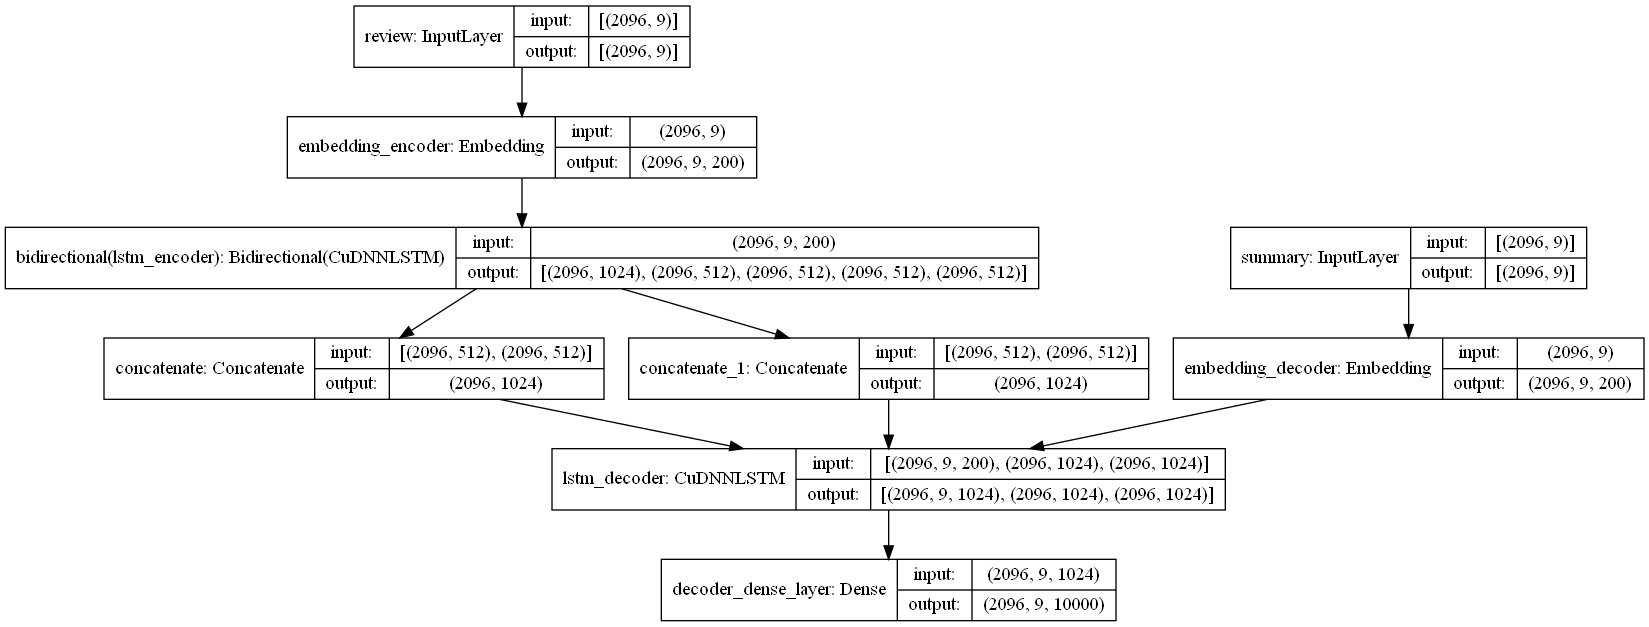

In [26]:
# Plot the model to an image
plot_model(model, to_file='model.png', show_shapes=True)

# Display the image in notebook
Image(filename='model.png')

In [27]:
# Trains the model
# model.fit_generator(generator=generate_batch_data(dataset), use_multiprocessing=True,
#                     epochs=1, steps_per_epoch=dataset['encoder_input'].shape[0] // BATCH_SIZE)

model.fit(generate_batch_data(dataset), use_multiprocessing=True, epochs=1, steps_per_epoch=dataset['encoder_input'].shape[0] // BATCH_SIZE)

Exception in thread Thread-10:
Traceback (most recent call last):
  File "C:\Users\Marcus\AppData\Local\Programs\Python\Python38\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\Marcus\AppData\Local\Programs\Python\Python38\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Marcus\Projects\summarize\venv\lib\site-packages\keras\utils\data_utils.py", line 868, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\Users\Marcus\Projects\summarize\venv\lib\site-packages\keras\utils\data_utils.py", line 858, in pool_fn
    pool = get_pool_class(True)(
  File "C:\Users\Marcus\AppData\Local\Programs\Python\Python38\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "C:\Users\Marcus\AppData\Local\Programs\Python\Python38\lib\multiprocessing\pool.py", line 212, in __init__
    self._repopulate_pool()
  File "C:

In [ ]:
# Save the model weights
model.save_weights('summarization_weights.h5')

In [ ]:
model.load_weights('summarization_weights.h5')

### 2. Inference model
Like training we have 2 separate models for encoder and decoder

#### 2.1 Encoder
From encoder we extract the thought vector to feed to the decoder

In [ ]:
# Define the inference model
encoder_inference_model = Model(review_input_layer, encoder_states)

# Plot the model
plot_model(encoder_inference_model, to_file="inference_encoder.png", show_shapes=True)

#### 2.2 Decoder
- 3 inputs to the decoder are: `previous time step hidden state`, `previous time step cell state` and `input at current timestep`
- For first time step we have though vector as, hidden state and cell state as inputs from previous time step
- After that, decoder cell is called recursively

In [ ]:
# Exactly same decoder model is used with diffrent input and output adjustments

# These states are required for feeding back to our next timestep decoder
decoder_state_input_h = Input(shape=(2 * LATENT_DIM,))
decoder_state_input_c = Input(shape=(2 * LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Now we shall reuse our decoder
summary_for_decoder = Input(shape=(1,))
embedding_summary_decoder = embedding_decoder_layer(summary_for_decoder)

decoder_inference_output, decoder_states_c, decoder_states_h = decoder_lstm_layer(
    embedding_summary_decoder, initial_state=decoder_states_inputs)
decoder_states_outputs = [decoder_states_c, decoder_states_h]
output_prob = decoder_dense_layer(decoder_inference_output)
decoder_inference_model = Model(
    [summary_for_decoder] + decoder_states_inputs,
    decoder_states_outputs + [output_prob])


In [ ]:
# Plot the decoder inference model
plot_model(decoder_inference_model, to_file='inference_decoder.png', show_shapes=True)

# Show the image
Image(filename='inference_decoder.png')

In [ ]:
def decode_sequence(input_sequence):
    # Encode the input as state vectors: states_h and states_c for decoder init
    encoder_states_value = encoder_inference_model.predict(input_sequence)

    # Generate empty target sequence of length 1, for decoder input
    # Populate the first character of target sequence with the start character
    target_sequence = np.zeros((1, 1))
    target_sequence[0, 0] = tokenize.word_index['start']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        h, c, output_tokens = decoder_inference_model.predict([target_sequence] + encoder_states_value, batch_size=1)

        # Sample a token
        sampled_word_index = np.argmax(output_tokens) 

        if sampled_word_index == 0:
            decoded_sentence += ['<pad>']
            continue
        sampled_word = indexToWordDict[sampled_word_index]
        decoded_sentence += [sampled_word]

        # Exit condition: either hit max length or find stop character
        if sampled_word == 'end' or len(decoded_sentence) > MAX_SEQUENCE_SUMMARY_LENGTH:
            stop_condition = True

            # Update the target sequence (of length 1)
            target_sequence[0, 0] = sampled_word_index

            # Update states
            encoder_states_value = [h, c]

        return ' '.join(decoded_sentence)

## Try it! 

In [ ]:
# The summarize function that takes in a text and summarize it
def summarize(input_sequence: str):
    input_sequence = pad_sequences(tokenize.texts_to_sequences([clean_text(input_sequence)]), MAX_SEQUENCE_REVIEW_LENGTH)
    return decode_sequence(input_sequence)

In [ ]:
summarize('The book was very nice, will read it again')

In [ ]:
summarize('very very bad book, didn\'t like it much')

In [ ]:
# Try if it's overfitting
for index, row in kindle_val_reviews.head(5).iterrows():
    print('Input review: ', row.review)
    print('Expected review: ', row.summary)
    print('Predicted output: ', summarize(row.review))
    print('\n')